# Sentiment Analysis
Sentiment analysis using Bidirectional Encoder Representations from Transformers classifier
* BERT model
* RoBERTa model

## Import and install required libraries

In [ ]:
import torch
import transformers
from tqdm import tqdm
from collections import Counter
import pandas as pd
import numpy as np
import re
import os
import seaborn as sb
import matplotlib.pyplot as plt 
sb.set() 
import nltk
import tensorflow as tf
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag, word_tokenize
from nltk.corpus import stopwords, wordnet
from torch.utils.data import Dataset, DataLoader,TensorDataset,RandomSampler, SequentialSampler
from transformers import BertModel, BertTokenizer,BertForSequenceClassification
import logging
logging.basicConfig(level=logging.ERROR)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
import torch.nn as nn
from transformers import BertModel
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.metrics import precision_recall_fscore_support, accuracy_score
import time
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.metrics import precision_recall_fscore_support
from transformers import RobertaTokenizer, RobertaModel, AdamW
import torch.nn as nn


## Read dataset

In [ ]:
train_data = pd.read_csv('../dataset/train_aug.csv')
test_data = pd.read_csv('../dataset/test.csv')
full_dataset_df = pd.read_csv('../dataset/full_dataset_final.csv')

## BERT model

In [ ]:
# Defining some key variables that will be used later on in the training
TRAIN_BATCH_SIZE = 16
VALID_BATCH_SIZE = 8
# EPOCHS = 1
LEARNING_RATE = 1e-05
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', truncation=True, do_lower_case=True)

In [ ]:
class SentimentClassifier(nn.Module):
    def __init__(self, n_classes):
        super(SentimentClassifier, self).__init__()
        self.bert = BertModel.from_pretrained('bert-base-uncased')
        self.drop = nn.Dropout(self.bert.config.hidden_dropout_prob)
        self.out = nn.Linear(self.bert.config.hidden_size, n_classes)

    def forward(self, input_ids, attention_mask):
        _, pooled_output = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask
        ,return_dict=False)
        
        output = self.drop(pooled_output)
    
        
#         print(input_ids.shape)
#         print(input_ids.dtype)
#         print(attention_mask.shape)
#         print(attention_mask.dtype)
#         print(type(pooled_output))
#         print(pooled_output)
        
        output = self.drop(pooled_output)
        return self.out(output)

In [ ]:
model = SentimentClassifier(n_classes=3, ).to(device)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
loss_fn = torch.nn.CrossEntropyLoss().to(device)

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
X_train, x_val, Y_train, y_val = train_test_split(train_data['clean_text'], train_data['manual_label'], test_size=0.2,stratify=train_data['manual_label'], random_state=42)

In [ ]:
X_test, y_test = test_data['clean_text'].to_numpy(), test_data['manual_label'].to_numpy()
X_full_dataset, Y_full_dataset = full_dataset_df['clean_text'].to_numpy(), [0]*full_dataset_df.shape[0]

In [ ]:
# Tokenize the text and convert them to PyTorch tensors
train_tokens = tokenizer.batch_encode_plus(
    X_train.values.tolist(),
    max_length=256,
    pad_to_max_length=True,
    truncation=True
)

val_tokens = tokenizer.batch_encode_plus(
    x_val.values.tolist(),
    max_length=256,
    pad_to_max_length=True,
    truncation=True
)

test_tokens = tokenizer.batch_encode_plus(
    X_test,
    max_length=256,
    pad_to_max_length=True,
    truncation=True
)


full_dataset_tokens = tokenizer.batch_encode_plus(
    X_full_dataset,
    max_length=256,
    pad_to_max_length=True,
    truncation=True
)

/home/UG/teog0015/.conda/envs/patenv/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:2346: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [ ]:
# Encode the labels as integers
label_encoder = LabelEncoder()
train_y_encoded = label_encoder.fit_transform(Y_train)
val_y_encoded = label_encoder.transform(y_val)
test_y_encoded = label_encoder.transform(y_test)

# One-hot encode the labels
onehot_encoder = OneHotEncoder(sparse=False, categories='auto')
train_y = onehot_encoder.fit_transform(train_y_encoded.reshape(-1, 1))
val_y = onehot_encoder.transform(val_y_encoded.reshape(-1, 1))
test_y = onehot_encoder.transform(test_y_encoded.reshape(-1, 1))

/home/UG/teog0015/.conda/envs/patenv/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [ ]:
train_seq = torch.tensor(train_tokens['input_ids'])
train_mask = torch.tensor(train_tokens['attention_mask'])
train_y = torch.tensor(train_y)

val_seq = torch.tensor(val_tokens['input_ids'])
val_mask = torch.tensor(val_tokens['attention_mask'])
val_y = torch.tensor(val_y)

test_seq = torch.tensor(test_tokens['input_ids'])
test_mask = torch.tensor(test_tokens['attention_mask'])
test_y = torch.tensor(test_y)

full_dataset_seq = torch.tensor(full_dataset_tokens['input_ids'])
full_dataset_mask = torch.tensor(full_dataset_tokens['attention_mask'])
full_dataset_y = torch.tensor(Y_full_dataset)

In [ ]:
train_data = TensorDataset(train_seq, train_mask, train_y)
train_dataloader = DataLoader(train_data, batch_size=TRAIN_BATCH_SIZE, shuffle=True)

In [ ]:
val_data = TensorDataset(val_seq, val_mask, val_y)
val_dataloader = DataLoader(val_data, batch_size=VALID_BATCH_SIZE, shuffle=True)

In [ ]:
test_data = TensorDataset(test_seq, test_mask, test_y)
test_dataloader = DataLoader(test_data, batch_size=VALID_BATCH_SIZE, shuffle=False)

In [ ]:
full_data = TensorDataset(full_dataset_seq, full_dataset_mask, full_dataset_y)
full_dataset_dataloader = DataLoader(full_data, batch_size=VALID_BATCH_SIZE, shuffle=False)

In [ ]:
# Training loop


print_freq = 20
epochs = 5

start = time.time()
for epoch in range(epochs):
    precision_ = 0
    recall_ = 0
    f1_ = 0
    print(f'Epoch {epoch + 1}/{epochs}')
    print('-' * 20)

    model.train()

    train_loss = 0
    for batch in tqdm(train_dataloader):
        batch_seq, batch_mask, batch_y = tuple(t.to(device) for t in batch)
        outputs = model(input_ids= batch_seq, attention_mask=batch_mask)
        loss = loss_fn(outputs, batch_y)
        train_loss += loss.item()
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    train_loss = train_loss / len(train_dataloader)
    print(f'Training loss: {train_loss:.4f}')

    model.eval()

    eval_loss = 0
    eval_acc = 0
    nb_eval_steps = 0
    predictions = []
    true_labels = []
    for batch in tqdm(val_dataloader):
        batch_seq, batch_mask, batch_y = tuple(t.to(device) for t in batch)
        with torch.no_grad():
            outputs = model(batch_seq, attention_mask=batch_mask)
        logits = outputs
        label_ids = batch_y.to('cpu').numpy()
        tmp_eval_accuracy = accuracy_score(np.argmax(label_ids, axis=1), np.argmax(logits.detach().cpu().numpy(), axis=1))
        eval_acc += tmp_eval_accuracy
        predictions.append(np.argmax(logits.detach().cpu(), axis=1))
        true_labels.append(np.argmax(label_ids, axis=1))
        loss = loss_fn(logits.detach().cpu(), batch_y.to('cpu').argmax(dim=1))
        eval_loss += loss.item()
        nb_eval_steps += 1
    
    eval_loss = eval_loss / nb_eval_steps
    eval_acc = eval_acc / len(val_dataloader)
    print(f'Validation loss: {eval_loss:.4f}')
    print(f'Validation Accuracy: {eval_acc:.4f}')

    # Compute precision, recall, and F1-score
    predictions = np.concatenate(predictions)
    true_labels = np.concatenate(true_labels)
    precision, recall, f1, _ = precision_recall_fscore_support(true_labels, predictions, average='weighted')
    precision_ += precision
    recall_ += recall
    f1_ += f1
    print(f'Validation Precision: {precision:.4f}')
    print(f'Validation Recall: {recall:.4f}')
    print(f'Validation F1-score: {f1:.4f}')

end = time.time()
print("Training time: {:.3f}".format(end-start))
torch.save(model.state_dict(), 'BertModel.pth')

Epoch 1/5
--------------------


100%|██████████| 111/111 [00:25<00:00,  4.31it/s]


Training loss: 0.7804


100%|██████████| 56/56 [00:02<00:00, 24.02it/s]


Validation loss: 0.4958
Validation Accuracy: 0.7902
Validation Precision: 0.7980
Validation Recall: 0.7905
Validation F1-score: 0.7909
Epoch 2/5
--------------------


100%|██████████| 111/111 [00:26<00:00,  4.25it/s]


Training loss: 0.4062


100%|██████████| 56/56 [00:02<00:00, 23.42it/s]


Validation loss: 0.3012
Validation Accuracy: 0.8750
Validation Precision: 0.8719
Validation Recall: 0.8761
Validation F1-score: 0.8710
Epoch 3/5
--------------------


100%|██████████| 111/111 [00:25<00:00,  4.29it/s]


Training loss: 0.2381


100%|██████████| 56/56 [00:02<00:00, 23.87it/s]


Validation loss: 0.2586
Validation Accuracy: 0.8929
Validation Precision: 0.9038
Validation Recall: 0.8941
Validation F1-score: 0.8967
Epoch 4/5
--------------------


100%|██████████| 111/111 [00:25<00:00,  4.30it/s]


Training loss: 0.1641


100%|██████████| 56/56 [00:02<00:00, 24.07it/s]


Validation loss: 0.2443
Validation Accuracy: 0.9018
Validation Precision: 0.9048
Validation Recall: 0.9032
Validation F1-score: 0.9037
Epoch 5/5
--------------------


100%|██████████| 111/111 [00:25<00:00,  4.31it/s]


Training loss: 0.1145


100%|██████████| 56/56 [00:02<00:00, 24.11it/s]


Validation loss: 0.2771
Validation Accuracy: 0.9018
Validation Precision: 0.9089
Validation Recall: 0.9009
Validation F1-score: 0.9027
Training time: 141.067


In [ ]:
# Test the model on the test set

model.eval()
test_loss = 0
test_acc = 0
nb_test_steps = 0
predictions = []
true_labels = []
start = time.time()
for batch in test_dataloader:
    batch_seq, batch_mask, batch_y = tuple(t.to(device) for t in batch)
    with torch.no_grad():
        outputs = model(batch_seq, attention_mask=batch_mask)
    logits = outputs
    label_ids = batch_y.to('cpu').numpy()
    tmp_eval_accuracy = accuracy_score(np.argmax(label_ids, axis=1), np.argmax(logits.detach().cpu().numpy(), axis=1))
    test_acc += tmp_eval_accuracy
    predictions.append(np.argmax(logits.detach().cpu(), axis=1))
    true_labels.append(np.argmax(label_ids, axis=1))
    loss = torch.nn.functional.cross_entropy(logits.detach().cpu(), batch_y.to('cpu').argmax(dim=1))
    test_loss += loss.item()
    nb_eval_steps += 1
    nb_test_steps +=1

end = time.time()
test_loss = test_loss / nb_test_steps
test_acc = test_acc / len(test_dataloader)
print(f'Test loss: {test_loss:.4f}')
print(f'Test Accuracy: {test_acc:.4f}')

# Compute precision, recall, and F1-score
test_predictions = np.concatenate(predictions)
test_true_labels = np.concatenate(true_labels)
precision, recall, f1, _ = precision_recall_fscore_support(test_true_labels, test_predictions, average='weighted')
print(f'Test Precision: {precision:.4f}')
print(f'Test Recall: {recall:.4f}')
print(f'Test F1-score: {f1:.4f}')
print("Evaluation time on test dataset: {:.3f}".format(end-start))

Test loss: 0.4769
Test Accuracy: 0.8400
Test Precision: 0.8469
Test Recall: 0.8400
Test F1-score: 0.8425
Evaluation time on test dataset: 1.992


In [ ]:
# Convert the predicted labels back to their original text labels
predicted_labels = label_encoder.inverse_transform(test_predictions)
actual_labels = label_encoder.inverse_transform(np.argmax(test_y, axis=1))

# Create a new DataFrame with the predicted labels and the original labels
results_df = pd.DataFrame({'clean_text': X_test, 'predicted_label': predicted_labels, 'actual_label': actual_labels})
results_df

,clean_text,predicted_label,actual_label
0,day mapo tofu healthy meal mean tofu got ta co...,pos,neu
1,azuki room magicwin cryptochazman yasirali nft...,neu,neu
2,nft lending agreement benddao ethereum reserve...,pos,pos
3,meebit bought eth usd blur meebits meebitsnft,pos,pos
4,sold punksticker new owner thanks enjoy nftcol...,pos,pos
...,...,...,...
395,meebits swept total eth usd blur meebits meebi...,pos,pos
396,voxel punkbit new owner sumrtime voxelpunkbits...,neu,pos
397,hmm mekaverse apekidsclub floor almost price n...,neu,neu
398,azuki sold eth nft collection azuki floor pric...,pos,pos


In [ ]:
# A helper function for displaying the report
def Classification_Report(y_true, y_pred):
    print(f"Classification Report:\n\n",classification_report(y_true, y_pred))

              precision    recall  f1-score   support

         neg       0.67      0.48      0.56        21
         neu       0.80      0.70      0.74       102
         pos       0.88      0.94      0.91       277

    accuracy                           0.85       400
   macro avg       0.78      0.70      0.74       400
weighted avg       0.85      0.85      0.85       400



## RoBERTa model

In [ ]:
# Defining some key variables that will be used later on in the training
TRAIN_BATCH_SIZE = 16
VALID_BATCH_SIZE = 8
# EPOCHS = 1
LEARNING_RATE = 1e-05
tokenizer = RobertaTokenizer.from_pretrained('roberta-base', truncation=True, do_lower_case=True)

In [ ]:
class SentimentClassifier(nn.Module):
    def __init__(self, n_classes):
        super(SentimentClassifier, self).__init__()
        self.roberta = RobertaModel.from_pretrained('roberta-base')
        self.drop = nn.Dropout(p=0.5)
        self.out = nn.Linear(self.roberta.config.hidden_size, n_classes)

    def forward(self, input_ids, attention_mask):
        _, pooled_output = self.roberta(
            input_ids=input_ids,
            attention_mask=attention_mask,
        return_dict=False)
        
        # print(input_ids.shape)
        # print(input_ids.dtype)
        # print(attention_mask.shape)
        # print(attention_mask.dtype)
        # print(type(pooled_output))
        # print(pooled_output)
        
        output = self.drop(pooled_output)
        return self.out(output)

In [ ]:
model = SentimentClassifier(n_classes=3).to(device)
model= model.to(device)

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.bias', 'lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
loss_fn = torch.nn.CrossEntropyLoss().to(device)

In [ ]:
X_train, x_val, Y_train, y_val = train_test_split(train_data['clean_text'], train_data['manual_label'], test_size=0.2,stratify=train_data['manual_label'], random_state=42)

In [ ]:
X_test, y_test = test_data['clean_text'].to_numpy(), test_data['manual_label'].to_numpy()
X_full_dataset, Y_full_dataset = full_dataset_df['clean_text'].to_numpy(), [0]*full_dataset_df.shape[0]

In [ ]:
# Tokenize the text and convert them to PyTorch tensors
train_tokens = tokenizer.batch_encode_plus(
    X_train.values.tolist(),
    max_length=256,
    pad_to_max_length=True,
    truncation=True
)

val_tokens = tokenizer.batch_encode_plus(
    x_val.values.tolist(),
    max_length=256,
    pad_to_max_length=True,
    truncation=True
)

test_tokens = tokenizer.batch_encode_plus(
    X_test,
    max_length=256,
    pad_to_max_length=True,
    truncation=True
)

full_dataset_tokens = tokenizer.batch_encode_plus(
    X_full_dataset,
    max_length=256,
    pad_to_max_length=True,
    truncation=True
)

/home/UG/teog0015/.conda/envs/patenv/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:2346: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [ ]:
# Encode the labels as integers
label_encoder = LabelEncoder()
train_y_encoded = label_encoder.fit_transform(Y_train)
val_y_encoded = label_encoder.transform(y_val)
test_y_encoded = label_encoder.transform(y_test)

# One-hot encode the labels
onehot_encoder = OneHotEncoder(sparse=False, categories='auto')
train_y = onehot_encoder.fit_transform(train_y_encoded.reshape(-1, 1))
val_y = onehot_encoder.transform(val_y_encoded.reshape(-1, 1))
test_y = onehot_encoder.transform(test_y_encoded.reshape(-1, 1))

/home/UG/teog0015/.conda/envs/patenv/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [ ]:
train_seq = torch.tensor(train_tokens['input_ids'])
train_mask = torch.tensor(train_tokens['attention_mask'])
train_y = torch.tensor(train_y)

val_seq = torch.tensor(val_tokens['input_ids'])
val_mask = torch.tensor(val_tokens['attention_mask'])
val_y = torch.tensor(val_y)

test_seq = torch.tensor(test_tokens['input_ids'])
test_mask = torch.tensor(test_tokens['attention_mask'])
test_y = torch.tensor(test_y)

full_dataset_seq = torch.tensor(full_dataset_tokens['input_ids'])
full_dataset_mask = torch.tensor(full_dataset_tokens['attention_mask'])
full_dataset_y = torch.tensor(Y_full_dataset)


In [ ]:
train_data = TensorDataset(train_seq, train_mask, train_y)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, batch_size=TRAIN_BATCH_SIZE, shuffle=True)

In [ ]:
val_data = TensorDataset(val_seq, val_mask, val_y)
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, batch_size=VALID_BATCH_SIZE, shuffle=True)

In [ ]:
test_data = TensorDataset(test_seq, test_mask, test_y)
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, batch_size=VALID_BATCH_SIZE, shuffle=False)

In [ ]:
full_data = TensorDataset(full_dataset_seq, full_dataset_mask, full_dataset_y)
full_dataset_dataloader = DataLoader(full_data, batch_size=VALID_BATCH_SIZE, shuffle=False)

In [ ]:
# Training loop
epochs = 5
start = time.time()
for epoch in range(epochs):
    precision_ = 0
    recall_ = 0
    f1_ = 0
    print(f'Epoch {epoch + 1}/{epochs}')
    print('-' * 20)

    model.train()

    train_loss = 0
    for batch in tqdm(train_dataloader):
        batch_seq, batch_mask, batch_y = tuple(t.to(device) for t in batch)
        optimizer.zero_grad()
        outputs = model(batch_seq, attention_mask=batch_mask)
        loss = loss_fn(outputs, batch_y)
        train_loss += loss.item()
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    train_loss = train_loss / len(train_dataloader)
    print(f'Training loss: {train_loss:.4f}')

    model.eval()

    eval_loss = 0
    eval_acc = 0
    nb_eval_steps = 0
    predictions = []
    true_labels = []
    for batch in tqdm(val_dataloader):
        batch_seq, batch_mask, batch_y = tuple(t.to(device) for t in batch)
        with torch.no_grad():
            outputs = model(batch_seq, attention_mask=batch_mask)
        logits = outputs
        label_ids = batch_y.to('cpu').numpy()
        tmp_eval_accuracy = accuracy_score(np.argmax(label_ids, axis=1), np.argmax(logits.detach().cpu().numpy(), axis=1))
        eval_acc += tmp_eval_accuracy
        predictions.append(np.argmax(logits.detach().cpu(), axis=1))
        true_labels.append(np.argmax(label_ids, axis=1))
        loss = loss_fn(logits.detach().cpu(), batch_y.to('cpu').argmax(dim=1))
        eval_loss += loss.item()
        
        nb_eval_steps += 1
    eval_loss = eval_loss / nb_eval_steps
    eval_acc = eval_acc / len(val_dataloader)
    print(f'Validation loss: {eval_loss:.4f}')
    print(f'Validation Accuracy: {eval_acc:.4f}')

    # Compute precision, recall, and F1-score
    predictions = np.concatenate(predictions)
    true_labels = np.concatenate(true_labels)
    precision, recall, f1, _ = precision_recall_fscore_support(true_labels, predictions, average='weighted')
    precision_ += precision
    recall_ += recall
    f1_ += f1
    print(f'Validation Precision: {precision:.4f}')
    print(f'Validation Recall: {recall:.4f}')
    print(f'Validation F1-score: {f1:.4f}')
end = time.time()
print("Training time: {:.3f}".format(end-start))
torch.save(model.state_dict(), 'RoBERTaModel.pth')

Epoch 1/5
--------------------


100%|██████████| 111/111 [00:27<00:00,  4.10it/s]


Training loss: 0.7964


100%|██████████| 56/56 [00:02<00:00, 22.48it/s]


Validation loss: 0.5119
Validation Accuracy: 0.7723
Validation Precision: 0.7848
Validation Recall: 0.7748
Validation F1-score: 0.7656
Epoch 2/5
--------------------


100%|██████████| 111/111 [00:28<00:00,  3.91it/s]


Training loss: 0.4207


100%|██████████| 56/56 [00:02<00:00, 22.83it/s]


Validation loss: 0.2960
Validation Accuracy: 0.8839
Validation Precision: 0.8898
Validation Recall: 0.8829
Validation F1-score: 0.8845
Epoch 3/5
--------------------


100%|██████████| 111/111 [00:27<00:00,  4.06it/s]


Training loss: 0.2815


100%|██████████| 56/56 [00:02<00:00, 24.24it/s]


Validation loss: 0.2232
Validation Accuracy: 0.9107
Validation Precision: 0.9113
Validation Recall: 0.9099
Validation F1-score: 0.9098
Epoch 4/5
--------------------


100%|██████████| 111/111 [00:26<00:00,  4.24it/s]


Training loss: 0.1978


100%|██████████| 56/56 [00:02<00:00, 24.97it/s]


Validation loss: 0.2554
Validation Accuracy: 0.9018
Validation Precision: 0.9057
Validation Recall: 0.9054
Validation F1-score: 0.9048
Epoch 5/5
--------------------


100%|██████████| 111/111 [00:26<00:00,  4.27it/s]


Training loss: 0.1337


100%|██████████| 56/56 [00:02<00:00, 24.98it/s]


Validation loss: 0.3536
Validation Accuracy: 0.8929
Validation Precision: 0.8963
Validation Recall: 0.8919
Validation F1-score: 0.8811
Training time: 146.744


In [ ]:
# Test the model on the test set

model.eval()

test_loss = 0
test_acc = 0
nb_test_steps = 0
predictions = []
true_labels = []
start = time.time()
for batch in test_dataloader:
    batch_seq, batch_mask, batch_y = tuple(t.to(device) for t in batch)
    with torch.no_grad():
        outputs = model(batch_seq, attention_mask=batch_mask)
    logits = outputs
    label_ids = batch_y.to('cpu').numpy()
    tmp_eval_accuracy = accuracy_score(np.argmax(label_ids, axis=1), np.argmax(logits.detach().cpu().numpy(), axis=1))
    test_acc += tmp_eval_accuracy
    predictions.append(np.argmax(logits.detach().cpu(), axis=1))
    true_labels.append(np.argmax(label_ids, axis=1))
    loss = torch.nn.functional.cross_entropy(logits.detach().cpu(), batch_y.to('cpu').argmax(dim=1))
    test_loss += loss.item()
    nb_eval_steps += 1
    nb_test_steps +=1

end = time.time()
test_loss = test_loss / nb_test_steps
test_acc = test_acc / len(test_dataloader)
print(f'Test loss: {test_loss:.4f}')
print(f'Test Accuracy: {test_acc:.4f}')

# Compute precision, recall, and F1-score
test_predictions = np.concatenate(predictions)
test_true_labels = np.concatenate(true_labels)
precision, recall, f1, _ = precision_recall_fscore_support(test_true_labels, test_predictions, average='weighted')
print(f'Test Precision: {precision:.4f}')
print(f'Test Recall: {recall:.4f}')
print(f'Test F1-score: {f1:.4f}')
print("Time taken for evaluation on test data: {:.3f}".format(end-start))

Test loss: 0.5275
Test Accuracy: 0.8375
Test Precision: 0.8397
Test Recall: 0.8375
Test F1-score: 0.8295
Time taken for evaluation on test data: 1.922


In [ ]:
# Convert the predicted labels back to their original text labels
predicted_labels = label_encoder.inverse_transform(test_predictions)
actual_labels = label_encoder.inverse_transform(np.argmax(test_y, axis=1))

# Create a new DataFrame with the predicted labels and the original labels
results_df = pd.DataFrame({'clean_text': X_test, 'predicted_label': predicted_labels, 'actual_label': actual_labels})
results_df


,clean_text,predicted_label,actual_label
0,day mapo tofu healthy meal mean tofu got ta co...,pos,neu
1,azuki room magicwin cryptochazman yasirali nft...,neu,neu
2,nft lending agreement benddao ethereum reserve...,pos,pos
3,meebit bought eth usd blur meebits meebitsnft,pos,pos
4,sold punksticker new owner thanks enjoy nftcol...,pos,pos
...,...,...,...
395,meebits swept total eth usd blur meebits meebi...,pos,pos
396,voxel punkbit new owner sumrtime voxelpunkbits...,pos,pos
397,hmm mekaverse apekidsclub floor almost price n...,pos,neu
398,azuki sold eth nft collection azuki floor pric...,pos,pos


In [ ]:
# A helper function for displaying the report
def Classification_Report(y_true, y_pred):
    print(f"Classification Report:\n\n",classification_report(y_true, y_pred))

              precision    recall  f1-score   support

         neg       0.62      0.86      0.72        21
         neu       0.78      0.73      0.75       102
         pos       0.91      0.91      0.91       277

    accuracy                           0.86       400
   macro avg       0.77      0.83      0.79       400
weighted avg       0.86      0.86      0.86       400



## Apply on full dataset

In [ ]:
full_dataset_predictions = []
model.eval()
start = time.time()
for batch in full_dataset_dataloader:
    batch_seq, batch_mask, batch_y = tuple(t.to(device) for t in batch)
    with torch.no_grad():
        outputs = model(batch_seq, attention_mask=batch_mask)
    logits = outputs
    full_dataset_predictions.append(np.argmax(logits.detach().cpu(), axis=1))
end = time.time()
print("Time taken for predictions on full dataset: {:.3f}".format(end-start))

Time taken for predictions on full dataset: 100.800


In [ ]:
full_dataset_predictions_concat = np.concatenate(full_dataset_predictions)
full_dataset_predicted_labels = label_encoder.inverse_transform(full_dataset_predictions_concat)

In [ ]:
full_dataset_df['roberta'] = full_dataset_predicted_labels

In [ ]:
counts = df['roberta'].value_counts()

counts

pos    14252
neu     4488
neg     1555
Name: RoBERTa Predictions, dtype: int64

<Axes: >

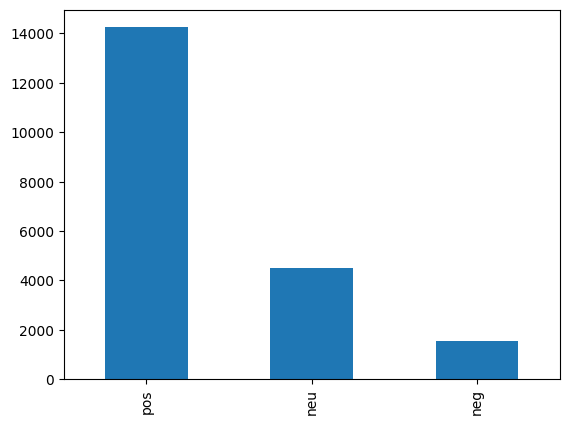

In [ ]:
df['roberta'].value_counts().plot.bar()

In [ ]:
full_dataset_df.to_csv('../dataset/BERT_full_dataset_final.csv', index=False)